
✅ Model Evaluation:
Features used: ['runtime', 'votes', 'year', 'decade', 'genre', 'director', 'actor_1', 'actor_2', 'actor_3', 'director_avg_rating', 'actor1_avg_rating']
RMSE: 0.71
R² Score: 0.73


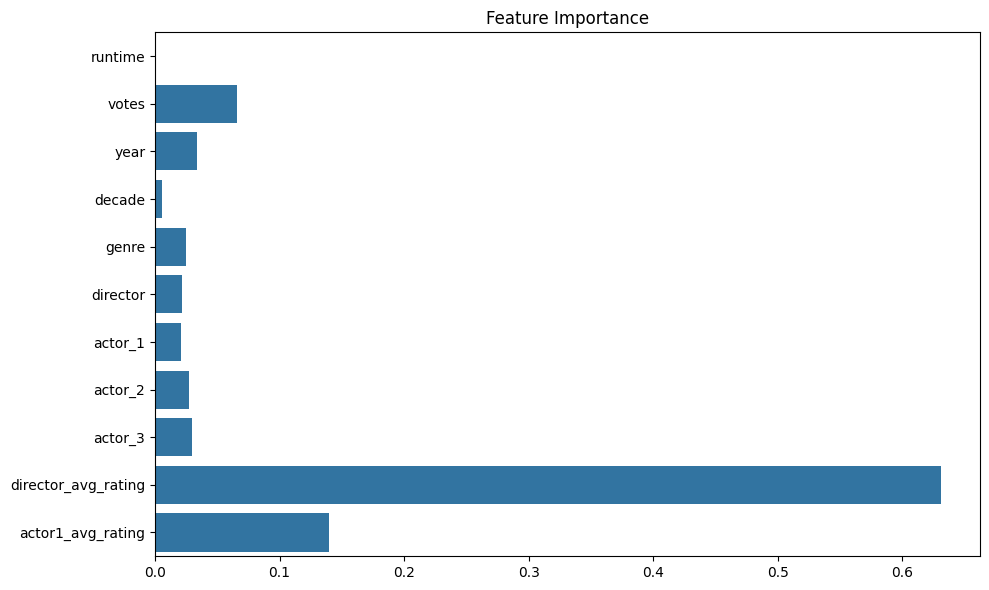

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/content/IMDb Movies India.csv', encoding='ISO-8859-1')

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# Rename columns based on what we found
df = df.rename(columns={'rating': 'imdb_rating', 'duration': 'runtime'})

# Clean and convert data
df['year'] = df['year'].str.extract('(\d+)').astype(float)  # Extract year from string
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'].str.replace(',', ''), errors='coerce')

# Handle missing values in target variable
df = df.dropna(subset=['imdb_rating'])  # Remove rows where rating is missing

# Fill other missing values
df['runtime'] = df['runtime'].fillna(df['runtime'].median())
df['votes'] = df['votes'].fillna(df['votes'].median())
df['year'] = df['year'].fillna(df['year'].median())

# Feature Engineering
# 1. Encode categorical features
for col in ['genre', 'director', 'actor_1', 'actor_2', 'actor_3']:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# 2. Create success metrics
if 'director' in df.columns:
    director_avg = df.groupby('director')['imdb_rating'].mean().to_dict()
    df['director_avg_rating'] = df['director'].map(director_avg)

if 'actor_1' in df.columns:
    actor1_avg = df.groupby('actor_1')['imdb_rating'].mean().to_dict()
    df['actor1_avg_rating'] = df['actor_1'].map(actor1_avg)

# 3. Create decade feature
df['decade'] = (df['year'] // 10) * 10

# Select features
features = []
potential_features = [
    'runtime', 'votes', 'year', 'decade',
    'genre', 'director', 'actor_1', 'actor_2', 'actor_3',
    'director_avg_rating', 'actor1_avg_rating'
]

for feat in potential_features:
    if feat in df.columns:
        features.append(feat)

# Prepare data
X = df[features]
y = df['imdb_rating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Model Evaluation:")
print(f"Features used: {features}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importance
if len(features) > 0:
    importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()